In [73]:
import tensorflow as tf
import numpy as np
import timeit
from sklearn.utils import shuffle
import time
import matplotlib.pyplot as plt
#import matplotlib.pyplot as plt
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)

<h1>Extract MNIST data</h1>

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
#get mnist data, with one_hot encoding, reshape = False (that means images are not flatten)
mnist = input_data.read_data_sets("MNIST_data/",reshape=False,one_hot=True)
#suppress warnings
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<h1>Prepare training, validation and testing data</h1>

In [55]:
x_train, y_train           = mnist.train.images, mnist.train.labels
x_validation, y_validation = mnist.validation.images, mnist.validation.labels
x_test, y_test             = mnist.test.images, mnist.test.labels

#pad images with 0s (28x28 to 32x32)
x_train_pad = np.pad(x_train, ((0,0), (2,2), (2,2), (0,0)), mode='constant', constant_values=0)
x_validation_pad = np.pad(x_validation, ((0,0), (2,2), (2,2), (0,0)), mode='constant', constant_values=0)
x_test_pad = np.pad(x_test, ((0,0), (2,2), (2,2), (0,0)), mode='constant', constant_values=0)

# will use a generator function...
def get_batches(datax, datay, batch_size):
    # need to shuffle here, but its chill
    datax_shuffle, datay_shuffle = shuffle(datax, datay, random_state=42)
    start = 0
    end = batch_size
    while end < len(datax_shuffle):
        yield (datax_shuffle[start:end], datay_shuffle[start:end])
        start += batch_size
        end += batch_size

<h1>Define hyperparameter</h1>

In [62]:
batch_size, num_epochs = 1024, 150

training_batches = get_batches(x_train_pad, y_train, batch_size)

In [63]:
tf.reset_default_graph()

<h1>Placeholder</h1>

In [64]:
x_in = tf.placeholder(tf.float32, shape=(None, 32, 32, 1))
y_true = tf.placeholder(tf.float32, shape=(None, 10))

<h1>Define LeNet-5</h1>

In [65]:
# LeNet 5 implements trainable average pooling layers
# in addition to convolutional layers that dont convolve over the
# whole feature map. Here we omit these features and
# copy the general structure, using max pool, and full conv layers
# They also use sigmoids in the convolution, omitted here
# and RBF for loss. we just use cross entropy

# c1: convolution2d
c1 = tf.layers.conv2d(x_in, filters=6, kernel_size=5, activation=tf.nn.sigmoid)

# s1: nontrainable ave pool substituted for trainable average pool
s1 = tf.layers.average_pooling2d(c1, pool_size=2, strides=2)

# c2: convolution 2d size (5,5, 10)
c2 = tf.layers.conv2d(s1, filters=16, kernel_size=5, activation=tf.nn.sigmoid)

# s3: nontrainable ave pool substitute for ave pool
s2 = tf.layers.average_pooling2d(c2, pool_size=2, strides=2)

# c4: 1x1 conv layer
c3 = tf.layers.conv2d(s2, filters=120, kernel_size=1, activation=tf.nn.sigmoid)

# flatten for fully connect
c3_flat = tf.layers.flatten(c3)

# dense
d4 = tf.layers.dense(c3_flat, units=84, activation=tf.nn.sigmoid)

# output
out = tf.layers.dense(d4, units=10)


<h1>Cost and optimization</h1>

In [66]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_true, logits=out))
opt = tf.train.AdamOptimizer()
to_minimize = opt.minimize(cost)

# compare prediction accuracy 
correct_pred = tf.equal(tf.argmax(tf.nn.softmax(out),1),tf.argmax(y_true,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')


<h1>Training, validating, testing</h1>
<h2>1. Print out validation accuracy after each training epoch</h2>
<h2>2. Print out training time on each epoch</h2>
<h2>3. Print out testing accuracy</h2>

In [67]:
init = tf.global_variables_initializer()
iter_count = 0
epochs, losses = [], []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_epochs):
        start = time.time()
        print("Training on Epoch \t" + str(i))
        training_batches = get_batches(x_train_pad, y_train, batch_size)
        for x_data, y_labels in training_batches:
            f_dict = {x_in: x_data, y_true: y_labels}
            sess.run(to_minimize, feed_dict=f_dict)
        losses.append(sess.run(cost, feed_dict=f_dict))
        epochs.append(i)
        current_acc = sess.run(accuracy, feed_dict=f_dict)
        print(current_acc)
        val_acc = sess.run(accuracy, feed_dict={x_in:x_validation_pad, y_true:y_validation})
        print('Validation Accuracy: \t ' + str(val_acc))
        print('Time for Epoch \t' + str(time.time() - start))
    test_acc = sess.run(accuracy, feed_dict={x_in:x_test_pad, y_true:y_test})
    print(test_acc)

Training on Epoch 	0
0.11035156
Validation Accuracy: 	 0.1126
Time for Epoch 	0.6282017230987549
Training on Epoch 	1
0.11035156
Validation Accuracy: 	 0.1126
Time for Epoch 	0.41866588592529297
Training on Epoch 	2
0.11035156
Validation Accuracy: 	 0.1126
Time for Epoch 	0.4174201488494873
Training on Epoch 	3
0.11035156
Validation Accuracy: 	 0.1126
Time for Epoch 	0.4179844856262207
Training on Epoch 	4
0.11035156
Validation Accuracy: 	 0.1126
Time for Epoch 	0.41698551177978516
Training on Epoch 	5
0.11035156
Validation Accuracy: 	 0.1126
Time for Epoch 	0.4178609848022461
Training on Epoch 	6
0.31054688
Validation Accuracy: 	 0.354
Time for Epoch 	0.41835498809814453
Training on Epoch 	7
0.6796875
Validation Accuracy: 	 0.708
Time for Epoch 	0.4189925193786621
Training on Epoch 	8
0.7910156
Validation Accuracy: 	 0.8314
Time for Epoch 	0.4157826900482178
Training on Epoch 	9
0.8457031
Validation Accuracy: 	 0.8748
Time for Epoch 	0.4108152389526367
Training on Epoch 	10
0.87109375

0.9902344
Validation Accuracy: 	 0.9824
Time for Epoch 	0.41816258430480957
Training on Epoch 	85
0.9902344
Validation Accuracy: 	 0.9822
Time for Epoch 	0.41823720932006836
Training on Epoch 	86
0.9902344
Validation Accuracy: 	 0.9826
Time for Epoch 	0.4174227714538574
Training on Epoch 	87
0.9902344
Validation Accuracy: 	 0.9832
Time for Epoch 	0.4187345504760742
Training on Epoch 	88
0.9902344
Validation Accuracy: 	 0.9836
Time for Epoch 	0.4181630611419678
Training on Epoch 	89
0.9902344
Validation Accuracy: 	 0.9836
Time for Epoch 	0.4184224605560303
Training on Epoch 	90
0.99121094
Validation Accuracy: 	 0.9836
Time for Epoch 	0.41742849349975586
Training on Epoch 	91
0.99121094
Validation Accuracy: 	 0.9836
Time for Epoch 	0.41853904724121094
Training on Epoch 	92
0.99121094
Validation Accuracy: 	 0.9832
Time for Epoch 	0.42069411277770996
Training on Epoch 	93
0.99121094
Validation Accuracy: 	 0.983
Time for Epoch 	0.41854047775268555
Training on Epoch 	94
0.99121094
Validation

Text(0, 0.5, 'Cost Function (Train Batch)')

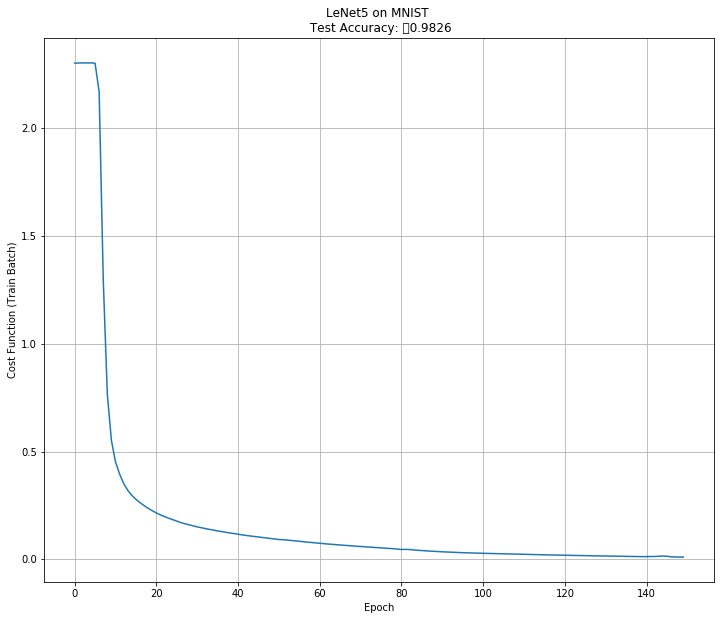

In [76]:
# i could only reach 98% acc ;C
plt.figure(1, figsize=(12,10))
plt.plot(epochs, losses)
plt.grid(True)
plt.title('LeNet5 on MNIST \n Test Accuracy: \t' + str(test_acc))
plt.xlabel('Epoch')
plt.ylabel('Cost Function (Train Batch)')